In [1]:
import joblib

from sklearn.model_selection import train_test_split

In [2]:
data = joblib.load('tot_segments_3.jbl').drop_duplicates()

In [3]:
data['Topic'] = data.Topic.apply(lambda row: '2.1. Контактное сопротивление (Абонент)' if row =='2.1. Контактное сопротивление' else row)

unique_topics = data['Topic'].unique()
val_to_id, id_to_val = {val:i for i, val in enumerate(unique_topics)}, {i:val for i,val in enumerate(unique_topics)}

data['binarized_target'] = data.Topic.apply(lambda x: val_to_id.get(x))

# bert

In [4]:
import os
import yaml
import random
import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
from IPython.display import clear_output

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas

import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler

import transformers
from transformers import AdamW
from transformers import (AutoTokenizer, AutoModel)

from transformers import (T5ForConditionalGeneration, T5Tokenizer)

/home/smurzakhmetov/train_bert/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import warnings
warnings.simplefilter('ignore')

In [6]:
MODEL_NAME = 'cointegrated/rut5-base-paraphraser'

paraphrase_model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
paraphrase_tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
paraphrase_model = paraphrase_model.cuda()

In [7]:
class CustomBERTModel(nn.Module):
    def __init__(self, num_classes, config):
        super(CustomBERTModel, self).__init__()
        self.bert = AutoModel.from_pretrained(config.get('bert_model'))
        self.linear1 = nn.Linear(config.get('hidden_size'), 256)
        self.linear2 = nn.Linear(256, num_classes)

    def forward(self, ids, mask):
        sequence_output = self.bert(ids, attention_mask=mask).last_hidden_state
        linear1_output = self.linear1(sequence_output[:, 0, :].view(-1,768))
        linear1_output = nn.functional.relu(linear1_output)
        linear2_output = self.linear2(linear1_output)
        return linear2_output


class BERTDataset(Dataset):
    def __init__(self, dataframe, config, is_test=False):
        self.dataframe = dataframe.reset_index(drop=True)
        self.is_test = is_test
        self.tokenizer = AutoTokenizer.from_pretrained(
            config.get('bert_model'), do_lower_case=True)
        self.max_len = config.get('max_len')
        self.aug_inserter = naw.ContextualWordEmbsAug(
            model_path="DeepPavlov/distilrubert-base-cased-conversational", 
            aug_p=0.2, action="insert")
        self.aug_masker = naw.ContextualWordEmbsAug(
            model_path="blinoff/roberta-base-russian-v0", aug_p=0.2)
        self.aug_translator = naw.back_translation.BackTranslationAug(
            from_model_name="Helsinki-NLP/opus-mt-ru-en", to_model_name='Helsinki-NLP/opus-mt-en-ru', device="cuda")

    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, idx):
        original_text = self.dataframe.loc[idx, 'Segment']
        randomized_select = random.random()
        
        if  0 < randomized_select <= 0.25:
            augmented_text = self.aug_inserter.augment(original_text)
        elif 0.25 < randomized_select <= 0.50:
            augmented_text = self.aug_translator.augment(original_text)
        elif 0.5 < randomized_select <= 0.75:
            augmented_text = self.paraphraser(original_text)
        else:
            augmented_text = original_text
        sentence = "[CLS] " + augmented_text + " [SEP]"
        global inputs
        inputs = self.tokenizer.encode_plus(
            sentence,
            None,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True
        )
        ids = torch.tensor(inputs['input_ids'], dtype=torch.long)
        mask = torch.tensor(inputs['attention_mask'], dtype=torch.long)
        
        if self.is_test:
            return {
                'ids': ids,
                'mask': mask,
            }
        else:
            targets = torch.tensor(
                [self.dataframe.loc[idx, 'binarized_target']])
            return {
                'ids': ids,
                'mask': mask,
                'targets': targets
            }
    
    def paraphraser(self, text, beams=5, grams=4, do_sample=False):
        x = paraphrase_tokenizer(text, return_tensors='pt', padding=True).to(paraphrase_model.device)
        max_size = int(x.input_ids.shape[1] * 1.5 + 10)
        out = paraphrase_model.generate(**x, encoder_no_repeat_ngram_size=grams,
                             num_beams=beams, max_length=max_size, do_sample=do_sample)
        return paraphrase_tokenizer.decode(out[0], skip_special_tokens=True)

In [8]:
class Util:
    scaler = GradScaler()


class Trainer:
    def __init__(
            self,
            model,
            optimizer,
            scheduler,
            train_dataloader,
            valid_dataloader,
            device,
            config
    ):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_data = train_dataloader
        self.valid_data = valid_dataloader
        self.loss_fn = self.yield_loss
        self.device = device
        self.config = config

    def yield_loss(self, outputs, targets):
        """
        This is the loss function for this task
        """
        return nn.CrossEntropyLoss()

    def train_one_epoch(self):
        """
        This function trains the model for 1 epoch through all batches
        """
        self.model.train()
        train_loss = 0
        for _, inputs in enumerate(self.train_data):
            self.optimizer.zero_grad()
            ids = inputs['ids'].to(self.device, dtype=torch.long)
            mask = inputs['mask'].to(self.device, dtype=torch.long)
            targets = inputs['targets'].to(self.device)
            outputs = self.model(ids=ids, mask=mask)
            outputs = nn.functional.log_softmax(outputs, dim=1)
            loss = criterion(outputs, targets.squeeze(1))
            Util.scaler.scale(loss).backward()

            train_loss += loss.item()
            Util.scaler.step(self.optimizer)
            Util.scaler.update()
            self.scheduler.step()
        res_loss = train_loss / len(self.train_data)
        return res_loss

    def valid_one_epoch(self):
        """
        This function validates the model for one epoch through all batches of the valid dataset
        It also returns the validation Root mean squared error for assesing model performance.
        """
        self.model.eval()
        all_targets = []
        all_predictions = []
        test_loss = 0
        with torch.no_grad():
            for _, inputs in enumerate(self.valid_data):
                ids = inputs['ids'].to(self.device, dtype=torch.long)
                mask = inputs['mask'].to(self.device, dtype=torch.long)
                targets = inputs['targets'].to(self.device)
                outputs = self.model(ids=ids, mask=mask)
                loss = criterion(
                    nn.functional.log_softmax(outputs, dim=1), targets.squeeze(1))
                outputs = outputs.detach().cpu().numpy()
                outputs = np.argmax(outputs, axis=1)
                all_targets.extend(targets.cpu().detach().numpy().tolist())
                all_predictions.extend(outputs.tolist())
                test_loss += loss.item()
        val_metrics = accuracy_score(all_targets, all_predictions) * 100
        res_loss = test_loss / len(self.valid_data)

        return val_metrics, res_loss

    def get_model(self):
        return self.model


def yield_optimizer(model, config):
    """
    Returns optimizer for specific parameters
    """
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.01,
        },
        {
            "params": [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]
    return AdamW(optimizer_parameters, lr=config.get('lr'))

In [9]:
Config = {
    'train':{
      'nb_epochs': 8,
      'lr': 0.00003,
      'max_len': 100,
      'hidden_size': 768,
      'train_bs': 32,
      'bert_model': 'DeepPavlov/rubert-base-cased',
      'experiment_name': 'intent_classification'  ,
      'file_name': 'data/train_data_augmented/data.csv',
      'freeze_ratio': 0,
      'cuda': 'cuda:0',
      'text_embeddings': {'bert':1, 'tfidf':0, 'fasttext':0},
      'simple_models': {'naive_bayes':0,'logreg':1,'svm':0,'sgd':0},
      'model_name': 'check_dataset_rubert_tiny',
      'last_layer': 'logreg'},

    'inference': {
      'val_size': 0.2,
      'valid_bs': 32,
      'max_len': 100,
      'bert_model': 'DeepPavlov/rubert-base-cased'},

    'evaluation': {
      'max_len': 100,
      'bert_model': 'DeepPavlov/rubert-base-cased',
      'freeze_ratio': 0,
      'hidden_size': 768,
      'eval_set_path': '/hdd/conda_kaldi/dvc_storage/clf_intent/val_set/gold_test_set.csv',
      'general_set_path': '/hdd/conda_kaldi/dvc_storage/clf_intent/general_set/nonmatched.csv',
    }
}

In [10]:
train_df, valid_df = train_test_split(data,
                                      test_size=0.2,
                                      stratify=data['binarized_target'], random_state=666)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else torch.device('cpu'))

train_set = BERTDataset(
    dataframe=train_df,
    config=Config.get('train')
)

valid_set = BERTDataset(
    dataframe=valid_df,
    config=Config.get('inference')
)

In [12]:
train = DataLoader(
    train_set,
    batch_size=Config.get('train')['train_bs'],
    shuffle=True,
    num_workers=0
)

valid = DataLoader(
    valid_set,
    batch_size=Config.get('inference')['valid_bs'],
    shuffle=False,
    num_workers=0
)


In [13]:
model = CustomBERTModel(num_classes=len(
    val_to_id), config=Config.get('train')).to(device)

nb_train_steps = (
    train_df.shape[0] / Config.get('train')['train_bs'] * Config.get('train')['nb_epochs'])

optimizer = yield_optimizer(model, Config.get('train'))

scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=nb_train_steps
)

trainer = Trainer(model, optimizer, scheduler, train,
                valid, device, Config.get('train'))

best_loss = 100

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

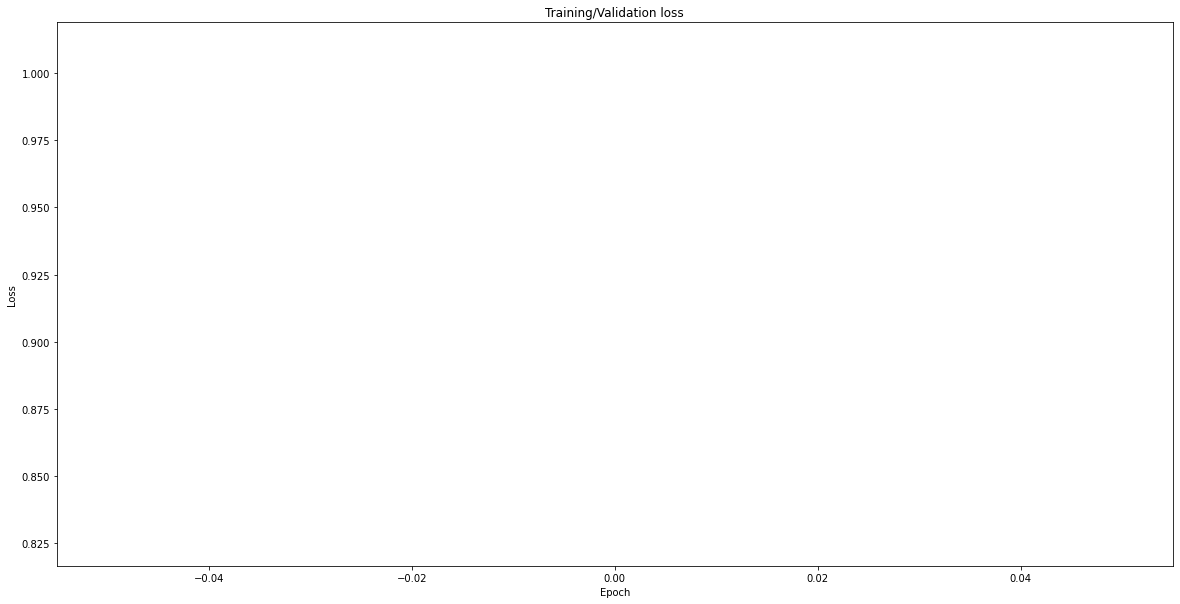

 12%|█▎        | 1/8 [06:08<43:01, 368.80s/it]


---------- EPOCH: 2 ----------



In [ ]:
criterion = nn.CrossEntropyLoss()

train_loss_set, valid_loss_set = [], []

for epoch in tqdm(range(1, Config['train'].get('nb_epochs') + 1)):
    print(f"\n{'--'*5} EPOCH: {epoch} {'--'*5}\n")

    # Train for 1 epoch
    epoch_loss = trainer.train_one_epoch()
    train_loss_set.append(epoch_loss)

    # Validate for 1 epoch
    val_accuracy, val_loss = trainer.valid_one_epoch()
    valid_loss_set.append(val_loss)
    
    clear_output(True)
    plt.figure(figsize=(20, 10))
    plt.plot(train_loss_set)
    plt.plot(valid_loss_set)
    plt.title("Training/Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()